In [1]:
import torch

In [2]:
model_path = './model.pth'

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
def load(fn, device):
    d = torch.load(fn, map_location=device)
    
    return d['model'], d['config']

In [7]:
model_dict, train_config = load(model_path, device)

print(train_config)

Namespace(model_fn='./model.pth', data_path='./cleaned_weather.csv', seq_length=24, forecast_horizon=24, n_epochs=5, batch_size=64, verbose=1, device=device(type='cpu'))


/tmp/ipykernel_4196/3056379413.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(fn, map_location=device)


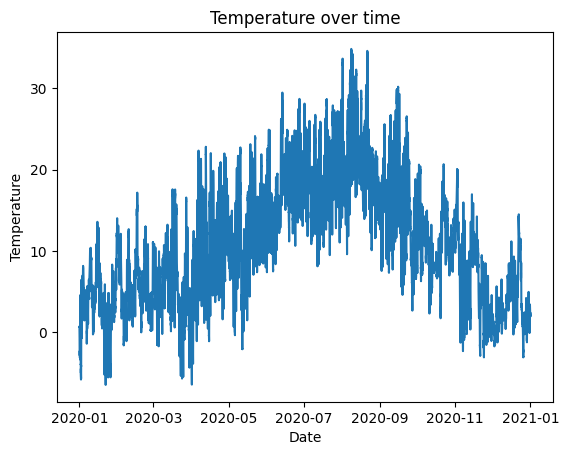

                       rh        p    wv     T
date                                          
2020-01-01 00:10:00  86.1  1008.89  1.02  0.71
2020-01-01 00:20:00  85.2  1008.76  0.43  0.75
2020-01-01 00:30:00  85.1  1008.66  0.61  0.73
2020-01-01 00:40:00  86.3  1008.64  1.11  0.37
2020-01-01 00:50:00  87.4  1008.61  0.49  0.33


In [ ]:
from utils import load_data

features = ['rh', 'p', 'wv']
target = 'T'
df = load_data(train_config, features, target)
print(df.head())

In [44]:
import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 데이터 준비
df = df.iloc[-24:]

ss = StandardScaler()
mm = MinMaxScaler()

df[features] = ss.fit_transform(df[features])
df[target] = mm.fit_transform(df[target].values.reshape(-1, 1))
df.drop(target, inplace=True, axis=1)

print(df.head())
print(df.shape)

# NumPy 배열로 변환 후 PyTorch 텐서로 변환
seq_tensor = torch.tensor(df.to_numpy(), dtype=torch.float32)
print(seq_tensor.shape)

seq_tensor.reshape(1, 24, 3)

                           rh         p        wv
date                                             
2020-12-31 20:10:00 -0.331683 -2.142688  0.886975
2020-12-31 20:20:00 -0.301553 -1.691155  1.036185
2020-12-31 20:30:00 -0.524516 -1.891836  1.235133
2020-12-31 20:40:00 -0.608880 -1.590815  0.862106
2020-12-31 20:50:00 -0.578750 -1.189453 -0.132632
(24, 3)
torch.Size([24, 3])


tensor([[[-0.3317, -2.1427,  0.8870],
         [-0.3016, -1.6912,  1.0362],
         [-0.5245, -1.8918,  1.2351],
         [-0.6089, -1.5908,  0.8621],
         [-0.5788, -1.1895, -0.1326],
         [-0.8077, -0.6878, -0.7792],
         [-0.8017, -0.5372, -0.8041],
         [-0.8559, -0.1359, -1.4755],
         [-0.9945, -0.0857, -0.2570],
         [-0.9102, -0.0355,  0.7626],
         [-0.6450,  0.2655,  1.0113],
         [-0.4522,  0.3157,  0.7129],
         [-0.3016,  0.5163,  0.4891],
         [-0.1388,  0.7170,  0.3399],
         [-0.1388,  1.0180,  0.4393],
         [-0.3016,  1.1184,  0.8372],
         [-0.4160,  1.0180,  1.1357],
         [ 0.0841,  1.0180,  0.9616],
         [ 0.1082,  1.0180, -0.0829],
         [ 0.6867,  0.8174, -0.9533],
         [ 2.5548,  0.7170, -1.6993],
         [ 2.0124,  0.5163, -1.8237],
         [ 1.5304,  0.5163, -1.3512],
         [ 2.1330,  0.4160, -1.3512]]])

In [47]:
from model import WeatherPredicter

input_size = len(features)
output_size = 24

model = WeatherPredicter(input_size, output_size)
model.load_state_dict(model_dict)
model.eval()

with torch.no_grad():
    y_pred = model(seq_tensor.reshape(1, 24, 3))
    print(y_pred)


prediction = mm.inverse_transform(y_pred)

tensor([[0.2652, 0.2558, 0.2822, 0.2887, 0.2848, 0.2649, 0.2980, 0.2593, 0.2884,
         0.2628, 0.2894, 0.2949, 0.2818, 0.2848, 0.2737, 0.3029, 0.2907, 0.2974,
         0.3045, 0.2871, 0.3087, 0.3083, 0.2914, 0.2994]])


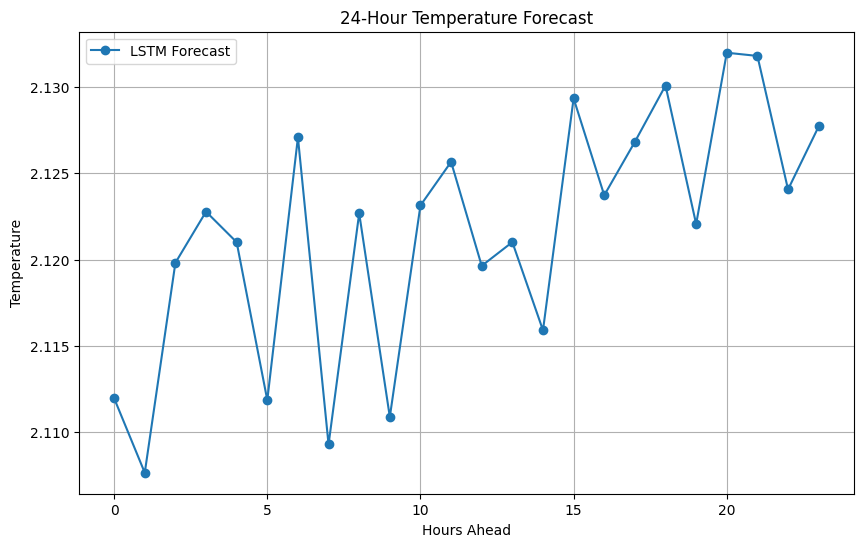

In [49]:
import matplotlib.pyplot as plt

# Plot forecast
fig, ax1 = plt.subplots(figsize=(10, 6))  # Create figure and axis
ax1.plot(range(24), prediction[0], label='LSTM Forecast', marker='o')  # Plot data
ax1.set_title('24-Hour Temperature Forecast')  # Title
ax1.set_xlabel('Hours Ahead')  # X-axis label
ax1.set_ylabel('Temperature')  # Y-axis label
ax1.legend()  # Legend
ax1.grid(True)  # Grid lines
plt.show()  # Display the plot